In [1]:
import numpy as np 
import pandas as pd 
import time
pd.set_option('display.max_columns', None) 



# PREPROCESAMIENTO
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


# PIPELINES
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import set_config
# configuración para mostrar los pipelines de modo grafico
set_config(display=None)


# MODELOS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier





# VISUALIACIÓN
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# ACÁ ENTRAN LOS DATOS
df = pd.read_csv('/content/twic_master.csv')

# ACÁ TENEMOS LOS DATOS CRUDOS

In [ ]:
# Casi 2 millones de partidas
df.shape

(678914, 29)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678914 entries, 0 to 678913
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   twic_number     678914 non-null  int64  
 1   White           678914 non-null  object 
 2   Black           678914 non-null  object 
 3   Date            678914 non-null  object 
 4   EventDate       678533 non-null  object 
 5   Event           678914 non-null  object 
 6   Result          678914 non-null  object 
 7   mainline_moves  675558 non-null  object 
 8   Site            678913 non-null  object 
 9   Online          678913 non-null  object 
 10  Round           678913 non-null  object 
 11  ECO             676340 non-null  object 
 12  Opening         673950 non-null  object 
 13  WhiteFideId     669859 non-null  float64
 14  BlackFideId     669848 non-null  float64
 15  WhiteElo        653508 non-null  float64
 16  BlackElo        653129 non-null  float64
 17  Variation 

Las columnas SetUp, FEN y Variant cuando no son nulas hacen referencia a la modalidad chess960. Voy a dropear los registros de esta modalidad, son alrededor de 550 partidas.

Las columnas PlyCount, Board, EventCategory, BlackTeam y WhiteTeam no me aportan nada interesante. Las primeras tres son casi todas nulas, y los equipos no interesan.

In [ ]:
# Primero me quedo solo con los registros nulos en las columnas relacionadas con la modalidad 960
# De este modo me voy a quedar con las partidas que NO son 960chess
df = df[ (df.Variant.isna()) & (df.FEN.isna()) & (df.SetUp.isna()) ]

# Despues tiro estas columnas que ya no me dicen nada
df = df.drop(["Variant", "FEN", "SetUp"], axis=1)

In [ ]:
# Tiro las columnas que no interesan
df = df.drop(["twic_number", "White", "Black", "Date", "EventDate", "Site", "Online", "Round", "ECO", "Variation", "WhiteTitle", "BlackTitle", "PlyCount", "Board", "EventCategory", "BlackTeam", "WhiteTeam"], axis=1)

In [ ]:
display(df.shape)
df.columns

(678799, 9)

Index(['Event', 'Result', 'mainline_moves', 'Opening', 'WhiteFideId',
       'BlackFideId', 'WhiteElo', 'BlackElo', 'EventType'],
      dtype='object')

In [ ]:
# Vamos a poner todas las letras en minuscula y eliminar espacios en los extremos
# En "mainline_moves" y "ECO" NO toco las mayúsculas ya tienen relevancia en la notación.
cols = ["Event", "Opening", "EventType"]
for feature in cols:
    
    df[feature] = df[feature].str.lower().str.strip()


In [ ]:
# filtramos los registros con resultados mal cargados
display(df.shape)
df = df[(df.Result=="1-0") | (df.Result=="0-1") | (df.Result=="1/2-1/2")]
display(df.shape)

(678799, 9)

(678780, 9)

In [ ]:
df.isna().sum()

Event                  0
Result                 0
mainline_moves      3340
Opening             4834
WhiteFideId         9055
BlackFideId         9065
WhiteElo           25404
BlackElo           25782
EventType         615027
dtype: int64

In [ ]:
# No puedo dejar registros con nulos de Elo

indexo = df[ (df.WhiteElo.isna()) | (df.BlackElo.isna()) | (df.WhiteFideId.isna()) | (df.BlackFideId.isna())].index
  
df.drop(indexo, inplace = True)
  
df.isna().sum()

Event                  0
Result                 0
mainline_moves      2745
Opening             4190
WhiteFideId            0
BlackFideId            0
WhiteElo               0
BlackElo               0
EventType         578365
dtype: int64

In [ ]:
# Pasemos los números de identificación fide que son tipo object a enteros:

df['WhiteFideId'] = pd.to_numeric(df['WhiteFideId']).convert_dtypes() 

df['BlackFideId'] = pd.to_numeric(df['BlackFideId']).convert_dtypes() 

# Así elimino comas que hacen que el mismo id se lea distinto

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636195 entries, 0 to 678912
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Event           636195 non-null  object 
 1   Result          636195 non-null  object 
 2   mainline_moves  633450 non-null  object 
 3   Opening         632005 non-null  object 
 4   WhiteFideId     636195 non-null  Int64  
 5   BlackFideId     636195 non-null  Int64  
 6   WhiteElo        636195 non-null  float64
 7   BlackElo        636195 non-null  float64
 8   EventType       57830 non-null   object 
dtypes: Int64(2), float64(2), object(5)
memory usage: 49.8+ MB


In [ ]:
# Ahora vuelvo los IDs a str, ya que luego les haré ohe
df.WhiteFideId = df.WhiteFideId.astype(str)
df.BlackFideId = df.BlackFideId.astype(str)

# Y los Elos los paso a enteros
df.WhiteElo = df.WhiteElo.astype(int)
df.BlackElo = df.BlackElo.astype(int)


df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636195 entries, 0 to 678912
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Event           636195 non-null  object
 1   Result          636195 non-null  object
 2   mainline_moves  633450 non-null  object
 3   Opening         632005 non-null  object
 4   WhiteFideId     636195 non-null  object
 5   BlackFideId     636195 non-null  object
 6   WhiteElo        636195 non-null  int64 
 7   BlackElo        636195 non-null  int64 
 8   EventType       57830 non-null   object
dtypes: int64(2), object(7)
memory usage: 48.5+ MB


In [ ]:
# redefinamos los valores del target:

def xgb_target(valor):
    if valor=="1-0":
        return 0
    if valor=="0-1":
        return 1
    if valor=="1/2-1/2":
        return 2
    
df["Result"] = df.Result.apply(lambda x: xgb_target(x))

In [ ]:
# En la columna "mainline_moves" vamos a dejar sólo el número de movimientos:
df["mainline_moves"] = df.mainline_moves.apply(lambda x: len(x.split())//3 if type(x)==str else x)


In [ ]:
# Hagamos un df con partidas blitz
df_bz = df[(df.Event.str.contains("blitz")) | (df.EventType.str.contains("blitz"))]
df_bz.shape

(38485, 9)

In [ ]:
df_bz.isna().sum()

Event                 0
Result                0
mainline_moves      217
Opening             334
WhiteFideId           0
BlackFideId           0
WhiteElo              0
BlackElo              0
EventType         29887
dtype: int64

In [ ]:
# Hagamos un df con partidas rápidas
df_rd = df[(df.Event.str.contains("rapid")) | (df.EventType.str.contains("rapid"))]
df_rd.shape

(22937, 9)

In [ ]:
df_rd.isna().sum()

Event                 0
Result                0
mainline_moves       66
Opening             168
WhiteFideId           0
BlackFideId           0
WhiteElo              0
BlackElo              0
EventType         20323
dtype: int64

In [ ]:
# Dropiemos "Event" y "eventtype" que ya nos separaron los controles de tiempo:
df_bz = df_bz.drop(["Event", "EventType"], axis=1)
df_rd = df_rd.drop(["Event", "EventType"], axis=1)

In [ ]:
# Sólo quedan algunos nans en las columnas de movidas y aperturas
display(df_bz.isna().sum())
display(df_rd.isna().sum())

Result              0
mainline_moves    217
Opening           334
WhiteFideId         0
BlackFideId         0
WhiteElo            0
BlackElo            0
dtype: int64

Result              0
mainline_moves     66
Opening           168
WhiteFideId         0
BlackFideId         0
WhiteElo            0
BlackElo            0
dtype: int64

Ahora con los dataframes separados en blitz y rapid, podemos empezar a ver si los resultados son separables a simple vista. Vamos con un pairplot.

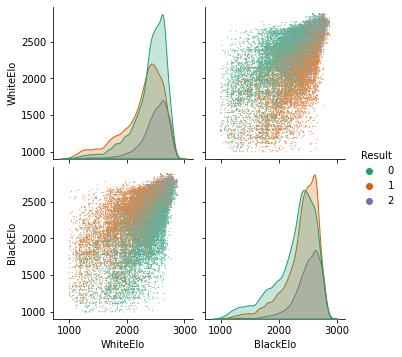

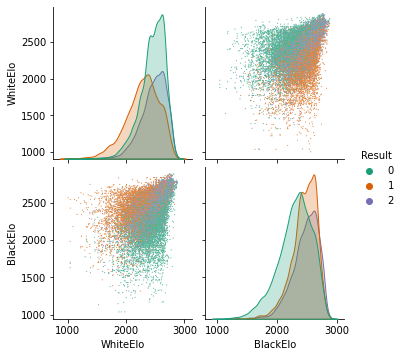

In [ ]:
sns.pairplot(df_bz, vars=['WhiteElo', 'BlackElo'], hue = "Result", plot_kws={"s": 1}, palette="Dark2")#, markers=["o", "s"])
sns.pairplot(df_rd, vars=['WhiteElo', 'BlackElo'], hue = "Result", plot_kws={"s": 1}, palette="Dark2")#, markers=["o", "s"])


# DATASETS LIMPIOS Y SEPARADOS POR CONTROL DE TIEMPO
AHORA ENTRAN LOS PIPELINES

In [3]:
# EN COLAB ARRANCO ACÁ:
#df_bz = pd.read_csv('/content/blitz_pipe.csv')
#df_rd = pd.read_csv('/content/rapid_pipe.csv')

In [4]:
df_rd.shape

(68587, 7)

In [5]:
df_bz.shape

(91377, 7)

In [6]:
# Separemos features y target
y_bz = df_bz.Result
X_bz = df_bz.drop(["Result"],axis=1)

X_bz.isna().sum()

mainline_moves    495
Opening           805
WhiteFideId         0
BlackFideId         0
WhiteElo            0
BlackElo            0
dtype: int64

In [7]:
X_bz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91377 entries, 0 to 91376
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mainline_moves  90882 non-null  float64
 1   Opening         90572 non-null  object 
 2   WhiteFideId     91377 non-null  int64  
 3   BlackFideId     91377 non-null  int64  
 4   WhiteElo        91377 non-null  int64  
 5   BlackElo        91377 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 4.2+ MB


## Definamos los transformers y usémolos para armar un pipeline:

In [8]:
# Hagamos un transformer para imputar
t1 = ColumnTransformer(
[('imputa_movidas', SimpleImputer(strategy='mean'), [0]),
('imputa_apertura', SimpleImputer(strategy='most_frequent'), [1])],
remainder='passthrough')


In [9]:
# Hagamos un transformer para hacer dummies de categóricas
# para que un jugador tenga su dummy, tiene que tener al menos 200 apariciones con el mismo color
# para que una apertura tenga su dummy, tiene que aparecer al menos 2000 veces
# después vamos a ver como se pueden optimizar este criterio desde un gridsearch
t2 = ColumnTransformer(
[('ohe_ids', OneHotEncoder(min_frequency=200, handle_unknown='infrequent_if_exist', sparse_output=False), [2,3]),
('ohe_apertura', OneHotEncoder(min_frequency=2000, handle_unknown='infrequent_if_exist', sparse_output=False), [1])],
remainder = 'passthrough')


In [10]:
# Hagamos un transformer que escalee las columnas numéricas (1 de movidas y 2 de elos)
# sé que estas 3 columnas están al final, porque los transformers van dejando atras las columnas sobre las que no actúan
t3 = ColumnTransformer([('escaleo', MinMaxScaler(), slice(-1,-4,-1))], remainder = "passthrough")


In [11]:
# Vamos con un arbol como modelo
arbol = DecisionTreeClassifier(max_depth=10) #para que no overfitee tanto

In [12]:
# Ahora creamos el pipeline con los transformers y el modelo:
# Es importante el nombre del último paso "clf"
pasos = [('tr1', t1), ('tr2', t2), ('tr3', t3), ('clf', arbol)]
pipe = Pipeline(pasos)

In [13]:
# En detalle, con los nombres de cada paso:
pipe.named_steps

{'tr1': ColumnTransformer(remainder='passthrough',
                   transformers=[('imputa_movidas', SimpleImputer(), [0]),
                                 ('imputa_apertura',
                                  SimpleImputer(strategy='most_frequent'),
                                  [1])]),
 'tr2': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe_ids',
                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                min_frequency=200,
                                                sparse_output=False),
                                  [2, 3]),
                                 ('ohe_apertura',
                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                min_frequency=2000,
                                                sparse_output=False),
                                  [1])]),
 'tr3': ColumnTransformer(

In [15]:
pipe.get_params()

{'memory': None, 'steps': [('tr1', ColumnTransformer(remainder='passthrough',
                     transformers=[('imputa_movidas', SimpleImputer(), [0]),
                                   ('imputa_apertura',
                                    SimpleImputer(strategy='most_frequent'),
                                    [1])])),
  ('tr2', ColumnTransformer(remainder='passthrough',
                     transformers=[('ohe_ids',
                                    OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                  min_frequency=200,
                                                  sparse_output=False),
                                    [2, 3]),
                                   ('ohe_apertura',
                                    OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                  min_frequency=2000,
                                                  sparse_output=False),
            

## Veamos paso a paso como actúa cada columntransformer sobre las features:

In [16]:
# PARA QUE SE VEA BIEN LO QUE HACE EL PIPELINE:

# MOSTRAMOS LA FEATURES ORIGINALES CON ALGUNOS NANS EN MOVIDAS Y APERTURAS
print("ANTES DE TRANSFORMAR:")
display(X_bz.shape)
display(X_bz.isna().sum())
display(X_bz.head())

X_1 = t1.fit_transform(X_bz)

# LUEGO DE LA TRANSFORMACION LOS NANS FUERON IMPUTADOS
# SE PIEDEN LOS NOMBRES DE LAS COLUMNAS, YA QUE CADA TRANSFORMER DEVUELVE UN ARRAY
# (POR ESO AL DEFINIR LOS TRANSFORMERS USO INDICES Y NO NOMBRES)
print("DESPUEST DE TR1:")
display(X_1.shape)
display(pd.DataFrame(X_1).isna().sum())
display(pd.DataFrame(X_1).head())

X_2 = t2.fit_transform(X_1)

# LA SEGUNDA TRANSFORMACION HACE OHE SOBRE LAS DOS COLUMNAS DE IDS Y LA DE APERTURAS
# LAS COLUMNAS SIN TRANSFORMAR QUEDAN AL FINAL
print("DESPUEST DE TR2:")
display(X_2.shape)
display(pd.DataFrame(X_2).head())

X_3 = t3.fit_transform(X_2)

# LA TERCERA TRANSFORMACIÓN SE HACE SOBRE LAS TRES COLUMNAS NUMERICAS Y LAS DEJA ADELANTE DE TODO
print("DESPUEST DE TR3:")
display(pd.DataFrame(X_3).head())



ANTES DE TRANSFORMAR:


(91377, 6)

mainline_moves    495
Opening           805
WhiteFideId         0
BlackFideId         0
WhiteElo            0
BlackElo            0
dtype: int64

,mainline_moves,Opening,WhiteFideId,BlackFideId,WhiteElo,BlackElo
0,76.0,sicilian,1503014,4170350,2835,2592
1,46.0,scandinavian (centre counter) defence,4151976,2016192,2517,2746
2,38.0,french,13300474,13702661,2765,2602
3,40.0,modern defence,13700316,4168119,2587,2763
4,46.0,giuoco piano,5000017,13504398,2773,2683


DESPUEST DE TR1:


(91377, 6)

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

,0,1,2,3,4,5
0,76.0,sicilian,1503014,4170350,2835,2592
1,46.0,scandinavian (centre counter) defence,4151976,2016192,2517,2746
2,38.0,french,13300474,13702661,2765,2602
3,40.0,modern defence,13700316,4168119,2587,2763
4,46.0,giuoco piano,5000017,13504398,2773,2683


DESPUEST DE TR2:


(91377, 86)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,76.0,2835,2592
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,46.0,2517,2746
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,2765,2602
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,40.0,2587,2763
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,46.0,2773,2683


DESPUEST DE TR3:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85
0,0.845827,0.975013,0.319328,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.927698,0.805954,0.193277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.851143,0.937799,0.159664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.936736,0.843169,0.168067,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.894205,0.942052,0.193277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Usemos el pipeline como un modelo:

In [17]:
# Hagamos un split en blitz:
X_train_bz, X_test_bz, y_train_bz, y_test_bz = train_test_split(X_bz, y_bz, test_size=0.2, random_state=0, stratify=y_bz)

In [18]:
# Entrenemos
pipe.fit(X_train_bz, y_train_bz)


Pipeline(steps=[('tr1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputa_movidas',
                                                  SimpleImputer(), [0]),
                                                 ('imputa_apertura',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [1])])),
                ('tr2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_ids',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=200,
                                                                sparse_output=False),
                                                  [2, 3]),
                                                 ('ohe_apertura',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=2000,
                                                                sparse_output=False),
                                                  [1])])),
                ('tr3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('escaleo', MinMaxScaler(),
                                                  slice(-1, -4, -1))])),
                ('clf', DecisionTreeClassifier(max_depth=10))])

In [19]:
# testeo
y_pred_bz = pipe.predict(X_test_bz)

accuracy_score(y_test_bz, y_pred_bz)

0.5856314291967608

## Metamos el pipeline dentro de un gridsearchcv para evaluar modelos e hiperparámetros al mismo tiempo:

In [24]:
# Y SI QUIERO COMPARAR CLASIFICADORES Y AL MISMO TIEMPO TUNEARLOS:

log_reg = LogisticRegression()
nb = BernoulliNB()
knn = KNeighborsClassifier()
svm = SVC()
mlp = MLPClassifier(max_iter=500)
dt = DecisionTreeClassifier()
et = ExtraTreesClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()


# con el nombre "clf" llamo a los distintos modelos
# con el doble guion bajo "__" accedo a los hiperparámetros
# el grid entra como una lista de diccionarios

parametros = [
    {'clf': [log_reg], 'clf__C': [0.01, 0.1, 1,2, 5, 10]},
    {'clf': [rf], 'clf__n_estimators': [50, 100, 200]},
    {'clf': [dt], 'clf__max_depth': [6, 7, 8, 9, 10]},
    {'clf': [nb]},
    {'clf': [mlp]},
    {'clf': [knn], 'clf__n_neighbors': [70, 100, 130, 160]},
    {'clf': [xgb], 'clf__colsample_bytree': [0.2, 0.4] 'clf__max_depth': [2, 3, 4, 5]}]


folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
search = GridSearchCV(pipe, parametros, cv=folds, scoring="f1_micro", n_jobs=-1)

In [25]:
ini = time.time()
search.fit(X_train_bz, y_train_bz)
fin = time.time()
print(f"{(fin-ini)/60} minutos de optimización")

5.2283615628878275 minutos de optimización


In [26]:
search.best_params_

{'clf': MLPClassifier(max_iter=500)}

In [27]:
res = pd.DataFrame(search.cv_results_).sort_values(by = "rank_test_score").set_index("rank_test_score").loc[:,["params","mean_test_score"]]#.sort_values(by = "rank_test_score")
res

,params,mean_test_score
rank_test_score,,
1,{'clf': MLPClassifier(max_iter=500)},0.593891
2,"{'clf': XGBClassifier(base_score=None, booster...",0.593426
3,"{'clf': XGBClassifier(base_score=None, booster...",0.592413
4,"{'clf': XGBClassifier(base_score=None, booster...",0.592359
5,"{'clf': XGBClassifier(base_score=None, booster...",0.591100
6,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.590566
7,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.590402
8,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.590088
9,"{'clf': XGBClassifier(base_score=None, booster...",0.588939


In [30]:
y_search_bz = search.predict(X_test_bz)

In [31]:
accuracy_score(y_test_bz, y_search_bz)

0.5941124972641716

## Visualicemos la performance del mejor modelo del gridsearch:

In [28]:
# Esta funcion toma los sets (X_test, y_test) y la predicción y_pred de un modelo
# Para entregar gráficas y métricas de score

def GRAFICAS(X_test, y_test, y_pred):
    
    y_test = pd.Series(y_test)
    y_pred = pd.Series(y_pred, index=y_test.index)
    
    c = confusion_matrix(y_test, y_pred) # mostramos la matriz de confusion
    plt.figure(figsize=(4  ,4))
    ax= plt.subplot()
    sns.heatmap(c, cmap="coolwarm", annot=True, fmt="d")
    ax.set_xlabel('Resultados predecidos')
    ax.set_ylabel('Resultados del test')
    ax.xaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.yaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.set_title('Matriz de Confusión')
    plt.show()
    

    print(f"El accuracy global del modelo es {accuracy_score(y_test, y_pred)}.")

    # Me armo un df de scores para cada resultado
    scores = pd.DataFrame({"Resultado":range(3),
                         "sensibilidad":pd.Series(recall_score(y_test, y_pred, average=None)),
                         "precisión":pd.Series(precision_score(y_test, y_pred, average=None)),
                         "f1":pd.Series(f1_score(y_test, y_pred, average=None))})
    scores.index.name='Resultado'
    print(f"\n\nEstos son los scores para cada resultado")

    display(scores.loc[:,"sensibilidad":].transpose().round(3))


    
    
    # hacemos un melt sobre Resultados para graficar
    df = scores.melt("Resultado", var_name='scores', value_name='Scores')
    # graficamos los scores para cada resultado
    sns.catplot(x="Resultado", y="Scores", hue='scores', data=df, kind='point')
    #plt.savefig(f"tp3_{type(modelo)}.png")
    plt.show()

    
    
    # Mostremos los errores cometidos

    err = y_test != y_pred # Hacemos una mascara de errores

    print(f"\n\nEstos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):") 

    err1 = pd.DataFrame({"Mal sensado":y_test[err].value_counts(), "Mal predecido":y_pred[err].value_counts()})
    tot1 = err1["Mal sensado"].sum()
    tot2 = err1["Mal predecido"].sum()
    err1.loc["Total"] = [tot1,tot2]
    err1.index.name='Resultado'
    display(err1.transpose())

    # Un dataframe de errores:
    errores = pd.DataFrame({"y_test":y_test[err], "y_pred":y_pred[err]})
    errores["frecuencia"] = errores.apply(lambda x: c[x.y_test,x.y_pred] ,axis=1)
    errores = errores.sort_values(by=["frecuencia",'y_test', 'y_pred'],ascending=[False,False,False])

    print(f"\n\nAquí se muestra la frecuencia de cada uno de los {errores.shape[0]} errores cometidos:")
    display (errores.drop_duplicates().set_index('frecuencia').transpose())

    
    
    # Y para finalizar graficamos los errores de predicción,
    # con la perspectiva puesta en Los Elos, que son nuestros
    # mejores predictores
    X_test["Errores de Sensibilidad"] = y_test
        
    X_test["Errores de Precisión"] = y_pred
    
    
    print("\n\nEstos son los errores de recall (etiquetas del test mal predecidas):")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Sensibilidad", plot_kws={"s": 1}, palette="Dark2")
    plt.show()

    # Acá se va a ver cómo los modelos predicen empates sólo para los jugadores de mayor Elo.
    print("\n\nEstos son los errores de precisión (predicciones erróneas del modelo):")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Precisión", plot_kws={"s": 1}, palette="Dark2")
    plt.show()
    print("Los errores de precisión a su vez revelan las fronteras de decisión del modelo")
    
    
    # Y un poco mas en detalle el tipo de error:
    X_err = X_test.loc[err]
    X_err["(Test, Pred)"] = X_err.apply(lambda x: (x["Errores de Sensibilidad"], x["Errores de Precisión"]), axis=1)
    
    print("\n\nAquí se grafican los seis tipos de errores posibles:")
    sns.pairplot(X_err, vars=['WhiteElo', 'BlackElo'], hue = "(Test, Pred)", plot_kws={"s": 1}, palette="Paired")
    plt.show()

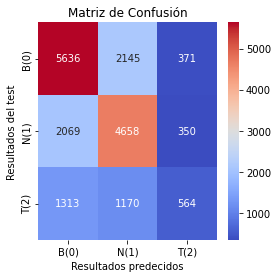

El accuracy global del modelo es 0.5941124972641716.


Estos son los scores para cada resultado


Resultado,0,1,2
sensibilidad,0.691,0.658,0.185
precisión,0.625,0.584,0.439
f1,0.656,0.619,0.260


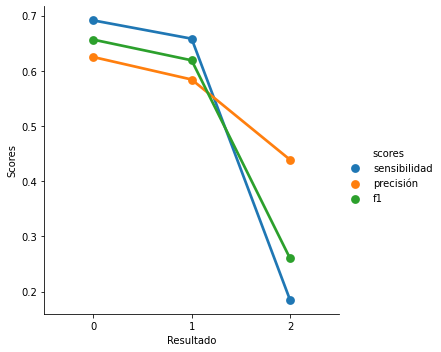



Estos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):


Resultado,0,1,2,Total
Mal sensado,2516,2419,2483,7418
Mal predecido,3382,3315,721,7418




Aquí se muestra la frecuencia de cada uno de los 7418 errores cometidos:


frecuencia,2145,2069,1313,1170,371,350
y_test,0,1,2,2,0,1
y_pred,1,0,0,1,2,2




Estos son los errores de recall (etiquetas del test mal predecidas):


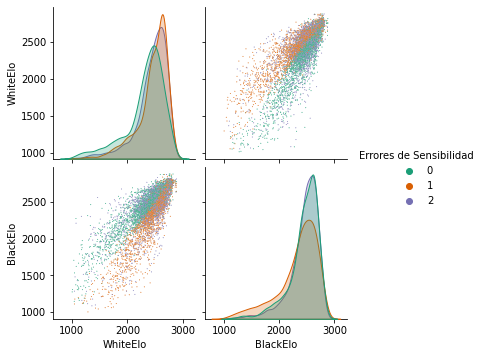



Estos son los errores de precisión (predicciones erróneas del modelo):


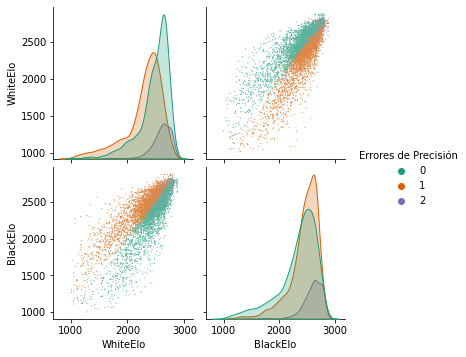

Los errores de precisión a su vez revelan las fronteras de decisión del modelo


Aquí se grafican los seis tipos de errores posibles:


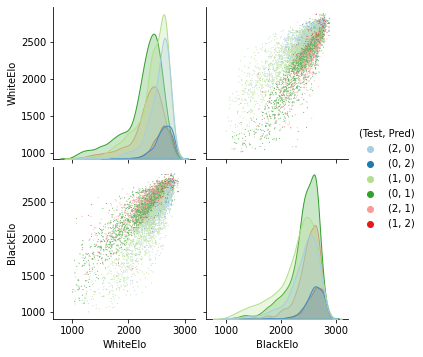

In [32]:
GRAFICAS(X_test_bz, y_test_bz, y_search_bz)

## Para afinar con xgb, podemos armar un pipeline cambiando el ultimo paso y metiendo el booster como clasificador:

In [33]:
# afinemos con xgb:
display(pasos[3])
#pongamos al xgb como ultimo paso:
pasos[3] = ("clf", xgb)
pipe_xgb = Pipeline(pasos)
display(pipe_xgb)

('clf', DecisionTreeClassifier(max_depth=10))

Pipeline(steps=[('tr1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputa_movidas',
                                                  SimpleImputer(), [0]),
                                                 ('imputa_apertura',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  [1])])),
                ('tr2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe_ids',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=200,
                                                                sparse_output=False),
                                                  [...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

Además quiero cambiar hiperparámetros de los transformers, por ejemplo la cantidad de dummies a generar.

In [55]:
# 

parametros_xgb = [
    {
     'clf': [xgb],
     'clf__colsample_bytree': [0.4, 0.6],
     'clf__max_depth': [3, 4],
     'clf__n_estimators': [400],
     'clf__learning_rate': [0.1, 0.15],
     'tr2__ohe_ids__min_frequency': [100,200,300], # acá me meto en los hiperparámetros del preprocesamiento
     'tr2__ohe_apertura__min_frequency': [2000,3000] # va ha probar con dummies para los jugadores que aparece más de 100, 200 ... veces
     # va a probar con dummies para las aperturas que aparecen más de 2000, 3000 ... veces
     
     }]



folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
search_xgb = GridSearchCV(pipe, parametros_xgb, cv=folds, scoring="f1_micro", n_jobs=-1)

También podría probar si es mejor imputar con la media o la mediana para las movidas, tendría que agregar:


```
'tr1__imputa_movidas__strategy': ["mean", "median"]
```
al grid de parámetros.


In [56]:

ini = time.time()
search_xgb.fit(X_train_bz, y_train_bz)
fin = time.time()
print(f"{(fin-ini)/60} minutos de optimización")


30.609608523050944 minutos de optimización


In [58]:
pd.DataFrame(search_xgb.cv_results_).sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__colsample_bytree,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,param_tr2__ohe_apertura__min_frequency,param_tr2__ohe_ids__min_frequency,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
47,24.113586,0.334868,1.649319,0.424288,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,3000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.589231,0.593160,0.591196,0.001964,45
44,24.570733,0.473732,1.198019,0.016313,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,2000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.589231,0.593160,0.591196,0.001964,45
43,23.872967,0.694758,1.289183,0.134993,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,2000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.589231,0.593160,0.591196,0.001964,45
46,24.696386,0.021811,1.186350,0.001207,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,3000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.589231,0.593160,0.591196,0.001964,45
22,16.484044,0.101468,0.983597,0.007221,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,3000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.589806,0.592613,0.591209,0.001403,41
20,16.120664,0.051126,1.107028,0.113360,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,2000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.589806,0.592613,0.591209,0.001403,41
19,16.064359,0.102789,1.001025,0.004330,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,2000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.589806,0.592613,0.591209,0.001403,41
23,16.111877,0.038510,0.969518,0.019105,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,3000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.589806,0.592613,0.591209,0.001403,41
41,19.016148,0.193140,0.926443,0.021881,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,3,400,3000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.591885,0.593078,0.592482,0.000596,37
40,19.114181,0.036485,1.751895,0.082704,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,3,400,3000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.591885,0.593078,0.592482,0.000596,37


In [60]:
y_search_xgb_bz = search_xgb.predict(X_test_bz)

In [61]:
accuracy_score(y_test_bz, y_search_xgb_bz)

0.6038520463996498

## Vamos con las rápidas

In [62]:
# Separemos features y target para rapidas
y_rd = df_rd.Result
X_rd = df_rd.drop(["Result"],axis=1)

X_rd.isna().sum()

mainline_moves    546
Opening           929
WhiteFideId         0
BlackFideId         0
WhiteElo            0
BlackElo            0
dtype: int64

In [63]:
# Hagamos un split:
X_train_rd, X_test_rd, y_train_rd, y_test_rd = train_test_split(X_rd, y_rd, test_size=0.2, random_state=0, stratify=y_rd)

In [64]:
# 

parametros_xgb = [
    {
     'clf': [xgb],
     'clf__colsample_bytree': [0.4, 0.6],
     'clf__max_depth': [3],
     'clf__n_estimators': [400],
     'clf__learning_rate': [0.075, 0.1],
     'tr2__ohe_ids__min_frequency': [50, 100], # acá me meto en los hiperparámetros del preprocesamiento
     'tr2__ohe_apertura__min_frequency': [2000, 3000] # va ha probar con dummies para los jugadores que aparece más de 100, 200 ... veces
     # va a probar con dummies para las aperturas que aparecen más de 2000, 3000 ... veces
     
     }]



folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
search_xgb = GridSearchCV(pipe, parametros_xgb, cv=folds, scoring="f1_micro", n_jobs=-1)

In [65]:
# Veamos como anda el pipeline con las rapidas
ini = time.time()
search_xgb.fit(X_train_rd, y_train_rd)
fin = time.time()
print(f"{(fin-ini)/60} minutos de optimización")

15.806938175360361 minutos de optimización


In [66]:
y_search_xgb_rd = search.predict(X_test_rd)

In [67]:
accuracy_score(y_test_rd, y_search_xgb_rd)

0.5962968362735093

In [70]:
search_xgb.best_params_

{'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.4, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.075, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=400, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 'clf__colsample_bytree': 0.4,
 'clf__learning_rate': 0.075,
 'clf__max_depth': 3,
 'clf__n_estimators': 400,
 'tr2__ohe_apertura__min_frequency': 2000,
 'tr2__ohe_ids__min_frequency': 50}